In [1]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np

In [3]:
buses = read_parquet_from_tar_gz("https://urbantech-public.s3.amazonaws.com/DO-NOT-DELETE-BUSOBSERVATORY-PUBLIC-DATASET/one-system-day.tar.gz")

In [4]:
df = pd.read_parquet('https://urbantech-public.s3.amazonaws.com/pickup/dump_NYC_GTFSRT/20240108_183520_00129_ygreg_ffbd96b2-8380-4c00-adbc-536f2fcb8079')

In [5]:
df['vehicle.trip.start_date'].value_counts()

vehicle.trip.start_date
20231024    137765
20230727    131072
20231214    126179
20231113    125261
20231201    122015
             ...  
20230604     26970
20231029     24638
20230529     20535
20230611     20336
20230427     16044
Name: count, Length: 257, dtype: int64

In [6]:
place = "New York City, New York, USA"
G = ox.graph_from_place(place, network_type='drive')

# Convert graph nodes to a DataFrame for KDTree
nodes = ox.graph_to_gdfs(G, edges=False).reset_index()
tree = KDTree(nodes[['y', 'x']], metric='euclidean')

In [7]:
# Query the KDTree for nearest node to each point
nearest_nodes = tree.query(np.array(buses[['lat', 'lon']]), k=1, return_distance=False)
buses['nearest_node'] = nearest_nodes.flatten()

# Map node IDs to OSM IDs
buses['nearest_osm_id'] = buses['nearest_node'].map(nodes['osmid'])
buses = buses.merge(nodes, left_on = "nearest_osm_id", right_on = "osmid")
buses = gpd.GeoDataFrame(buses, geometry='geometry')

In [8]:
buses["time_diff"] = buses.groupby("trip_id")["timestamp"].diff().dt.total_seconds()
buses = buses.query("time_diff >= 60")

In [9]:
buses_with_nodes = buses.sort_values(["trip_id", "timestamp"]).drop_duplicates(subset = ["trip_id", "nearest_osm_id"],  keep = "first").to_crs(2263)
buses_with_nodes = buses_with_nodes[["route", "timestamp", "trip_id", "osmid", "vehicle_id",  "geometry"]]
buses_with_nodes["prev_osmid"] = buses_with_nodes.groupby("trip_id")["osmid"].shift()

In [10]:
def compute_distance(row, graph):
    try:
        return nx.shortest_path_length(graph, row['prev_osmid'], row['osmid'], weight='length')
    except nx.NetworkXNoPath:
        return float('nan')
    
def compute_euclid_dists(node_pairs, nodes_points):
    node_pairs = node_pairs.merge(nodes_points, left_on = "osmid", right_on = "osmid", how = "left").merge(nodes_points, right_on = "osmid", left_on = "prev_osmid", how = "left", suffixes = ["curr", "prev"])
    node_pairs["x_diff_sq"] = (node_pairs["xcurr"] - node_pairs["xprev"])**2
    node_pairs["y_diff_sq"] = (node_pairs["ycurr"] - node_pairs["yprev"])**2

    return (node_pairs["x_diff_sq"] + node_pairs["y_diff_sq"]) ** (1/2)

nodes_points = nodes.to_crs(2263)
nodes_points["x"] = nodes_points.geometry.x
nodes_points["y"] = nodes_points.geometry.y
nodes_points = nodes_points[["osmid", "x", "y"]]

unqiue_node_pairs = buses_with_nodes[["osmid", "prev_osmid"]].dropna().drop_duplicates().astype("Int64").reset_index()
unqiue_node_pairs["distance_meters_osm"] = unqiue_node_pairs.apply(compute_distance, graph=G, axis=1)
unqiue_node_pairs["distance_meters_euclid"] = compute_euclid_dists(unqiue_node_pairs, nodes_points) / 3.28

unqiue_node_pairs.to_parquet("data/node_pairs.parquet")

unique_node_pairs = pd.read_parquet("data/node_pairs.parquet")
buses_with_nodes = buses_with_nodes.merge(unique_node_pairs, how = "left")
buses_with_nodes["osmid"] = buses_with_nodes["osmid"].astype(str)
buses_with_nodes["prev_osmid"] = buses_with_nodes["prev_osmid"].astype("Int64").astype(str)

In [17]:
buses_with_nodes["time_diff_seconds"] = buses_with_nodes.groupby("trip_id")["timestamp"].diff().dt.total_seconds()
buses_with_nodes["speed_mph_osm"] =  (buses_with_nodes["distance_meters_osm"] / 1609) / (buses_with_nodes["time_diff_seconds"] / 3600)
buses_with_nodes["speed_mph_euclid"] =  (buses_with_nodes["distance_meters_euclid"] / 1609) / (buses_with_nodes["time_diff_seconds"] / 3600)

In [18]:
unqiue_node_pairs

,index,osmid,prev_osmid,distance_meters_osm,distance_meters_euclid
0,1669752,42971120,42952118,206.579,206.356691
1,1670341,42971112,42971120,410.265,409.824293
2,1670923,42962132,42971112,570.504,401.598082
3,1670013,42965719,42955712,483.900,379.680800
4,1670584,42965724,42965719,173.052,172.722905
...,...,...,...,...,...
244669,1529217,42961868,42978240,430.090,429.156779
244670,1858971,43003233,42946631,1159.058,749.803972
244671,1859741,42995428,43003233,530.619,530.039548
244672,1593434,42978095,42973998,963.011,963.330683


In [19]:
compute_euclid_dists(unqiue_node_pairs, nodes_points) / 3.28

0         206.356691
1         409.824293
2         401.598082
3         379.680800
4         172.722905
             ...    
244669    429.156779
244670    749.803972
244671    530.039548
244672    963.330683
244673    788.538731
Length: 244674, dtype: float64

In [20]:
nodes.query("osmid == 42949762 | osmid == 598367717")

,osmid,y,x,ref,highway,street_count,geometry
34130,42949762,40.602807,-74.057823,NaN,stop,5,POINT (-74.05782 40.60281)
44155,598367717,40.601605,-74.062733,NaN,NaN,3,POINT (-74.06273 40.60160)


In [21]:
buses_with_nodes.query("speed_mph_osm > 100")

,route,timestamp,trip_id,osmid,vehicle_id,geometry,prev_osmid,index,distance_meters_osm,distance_meters_euclid,time_diff_seconds,speed_mph_osm,speed_mph_euclid
46,SIM3C,2023-07-05 00:06:44,MTA NYCT_CA_C3-Saturday-140500_MISC_360,42949767,MTA NYCT_2502,POINT (968884.407 159556.101),598365323,1670618.0,4389.665,2117.366379,60.0,163.691672,78.957105
147,SIM33C,2023-07-05 00:19:47,MTA NYCT_CA_C3-Saturday-142000_MISC_369,598229486,MTA NYCT_2651,POINT (982625.847 187538.268),607911351,603418.0,5516.712,2338.684021,122.0,101.173538,42.890210
153,SIM33C,2023-07-05 00:26:56,MTA NYCT_CA_C3-Saturday-142000_MISC_369,448096469,MTA NYCT_2651,POINT (974352.575 161675.277),42466639,332780.0,7412.139,1188.759669,61.0,271.869305,43.602429
154,SIM33C,2023-07-05 00:27:57,MTA NYCT_CA_C3-Saturday-142000_MISC_369,42949767,MTA NYCT_2651,POINT (968884.407 159556.101),448096469,333256.0,6622.814,1787.941903,61.0,242.917711,65.579790
314,SIM3C,2023-07-05 00:42:31,MTA NYCT_CA_C3-Saturday-143500_MISC_386,42949767,MTA NYCT_2573,POINT (968884.407 159556.101),94436414,400445.0,5060.799,2028.482525,61.0,185.624677,74.402562
...,...,...,...,...,...,...,...,...,...,...,...,...,...
928370,S61,2023-07-05 23:40:46,MTA NYCT_YU_C3-Weekday-SDon-139500_S6191_470,42964909,MTA NYCT_8577,POINT (955960.661 164247.615),42965730,1455917.0,3320.777,3145.714701,51.0,145.685387,138.005251
928402,SIM1C,2023-07-05 23:52:02,MTA NYCT_YU_C3-Weekday-SDon-139800_SIM1_570,42444353,MTA NYCT_2560,POINT (980246.671 195458.518),42478292,1859648.0,4896.660,3599.093973,67.0,163.520273,120.189033
928403,SIM1C,2023-07-05 23:53:33,MTA NYCT_YU_C3-Weekday-SDon-139800_SIM1_570,5487759985,MTA NYCT_2560,POINT (982755.693 189136.644),42444353,1642641.0,5684.558,2073.647837,91.0,139.766074,50.984723
928409,SIM1C,2023-07-05 23:59:39,MTA NYCT_YU_C3-Weekday-SDon-139800_SIM1_570,5882645228,MTA NYCT_2560,POINT (979506.853 168674.767),598322078,1595297.0,4216.049,1349.022194,61.0,154.640153,49.480686


In [22]:
buses_with_nodes['distance_diff_feet'] = buses_with_nodes.groupby('trip_id').apply(calculate_distances).reset_index(level=0, drop=True)

NameError: name 'calculate_distances' is not defined

<Axes: >

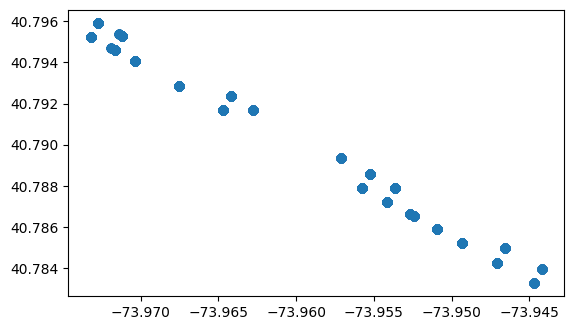

In [23]:
buses.query("route == 'M96'").plot()

In [26]:
path_nodes = nx.shortest_path(G, 598367717, 42949762)


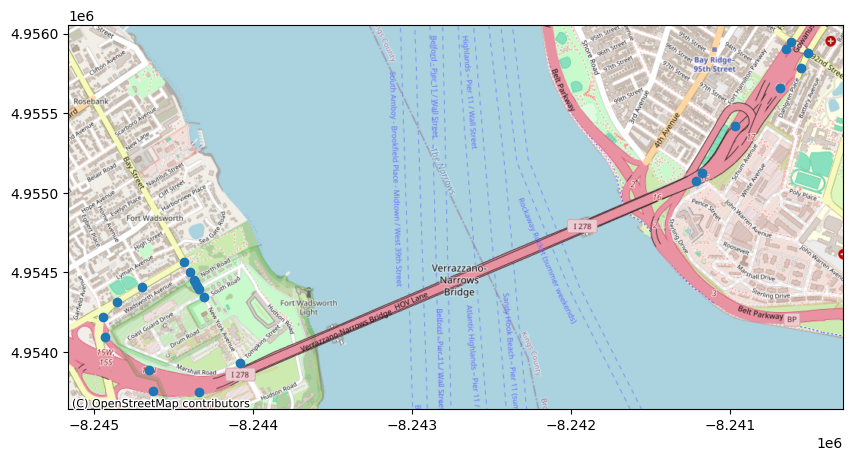

In [27]:
import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
nodes.query("osmid.isin(@path_nodes)").to_crs(3857).plot(ax = ax)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()
